# ADA / Applied Data Analysis
<h2 style="color:#a8a8a8">Homework 5 - Taming text<br>
Aimée Montero, Alfonso Peterssen, Cyriaque Brousse</h2>

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.<br><br>

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?<br><br>

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.<br><br>

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

## Part 1 - Word clouds

Let's first import the required libraries for the homework:

In [734]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's take a look at our data:

In [735]:
data = pd.read_csv("./hillary-clinton-emails/Emails.csv")
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We want to keep only the fields that contain text data. That is, `ExtractedSubject` and `ExtractedBodyText`.<br>
We concatenate the two fields for each email, ignoring the `NA` values.

In [736]:
mails = pd.DataFrame(data.ExtractedSubject.fillna('') + data.ExtractedBodyText.fillna(''))
mails.columns = ['EmailText']
mails.head()

,EmailText
0,FW: Wow
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Re: Chris StevensThx
3,FVV: Cairo Condemnation - Final
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


### First wordcloud attempt

We need to concatenate the text of all emails into one single string:

In [737]:
raw_mails = ' '.join(mails.EmailText)
raw_mails[:130]

'FW: Wow B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 03031'

We display a first wordcloud without doing any preprocessing step:

In [738]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(raw_mails)

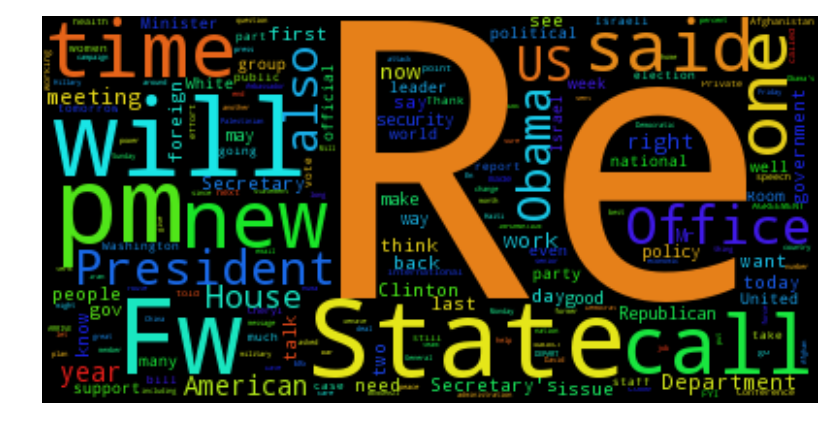

In [739]:
plt.subplots(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

A first problem is that the cloud contains many parasite tokens that are not words that bring much information to us: for instance, "Fw", "Re", "pm", "am", etc.<br>
We also notice that there are also actual words like "new", "call", "one", that don't bring any information either. These so-called **stopwords** need to be removed.

### Tokenization

For now, `raw_mails` is just a long string where every email and its subject is concatenated:

In [740]:
print(type(raw_mails), len(raw_mails))

<class 'str'> 3773276


What we want is to tokenize this string into separate words. This is done with a **tokenizer**:

In [741]:
from nltk import word_tokenize

In [742]:
def tokenizer(row) :
    return word_tokenize(row)

In [743]:
tokens = mails.EmailText.apply(lambda mail: tokenizer(mail))
tokens.head()

0                                         [FW, :, Wow]
1    [B6, Thursday, ,, March, 3, ,, 2011, 9:45, PM,...
2                           [Re, :, Chris, StevensThx]
3              [FVV, :, Cairo, Condemnation, -, Final]
4    [H, <, hrod17, @, clintonemail.com, >, Friday,...
Name: EmailText, dtype: object

### Lowerization

We want to transform all the tokens to lowercase, with the notable exception of `US` (the country) that risks being matched to `us` (the pronoun).

In [744]:
def to_lower_case(row_token) :
    return [w.lower() if w not in ['US', 'U.S.'] else w for w in row_token]
lowercase_tokens = tokens.apply(lambda row : to_lower_case(row))

### Punctuation and stopwords

To remove the stopwords, we use a **stopword dictionary** provided by the NLTK API.<br>
Additionally, we remove the punctuation marks.

In [745]:
from string import punctuation
from nltk.corpus import stopwords
import nltk

In [746]:
long_sw = [line.strip() for line in open("StopWords", 'r')]

In [747]:
custom_sw = ['tv', '\'s', '\'\'','http','subject', 'cc', 'pm', 'am', 're', 'fw', 'fvv', '…', 'n\'t']
stop = stopwords.words('english') + list(punctuation) + custom_sw + long_sw

In [748]:
def filter_tokens(row_lower_case_tokens) :
    alphabetic_str = list(filter(lambda w: '\'' in w or w.isalpha() or w.isdigit(), row_lower_case_tokens))
    words = list(filter(lambda w: 'i' == w or len(w) > 1, alphabetic_str))
    return list(filter(lambda w: w not in stop, words))

In [749]:
filtered_tokens = lowercase_tokens.apply(lambda row: filter_tokens(row))
filtered_tokens.head()

0                                                [wow]
1    [thursday, march, 2011, latest, syria, aiding,...
2                                  [chris, stevensthx]
3                         [cairo, condemnation, final]
4    [friday, march, 11, 2011, huma, abedin, latest...
Name: EmailText, dtype: object

### Stemming

We are now trying to map each token to its stem. For example:
- `reading => read`
- `reader => read`
- `read => read`

In [750]:
stemmer = nltk.PorterStemmer()

In [751]:
def porter_stemmer(row_tokens) :
    return [stemmer.stem(token) for token in row_tokens]

In [752]:
stems = filtered_tokens.apply(lambda row : porter_stemmer(row))
stems.head(3)

0                                                [wow]
1    [thursday, march, 2011, latest, syria, aid, qa...
2                                   [chri, stevensthx]
Name: EmailText, dtype: object

In [753]:
def join(df) :
    tokens_to_string = df.apply(lambda x : ' '.join(x))
    return ' '.join(tokens_to_string)
raw_text = join(stems)
raw_text[:30]

'wow thursday march 2011 latest'

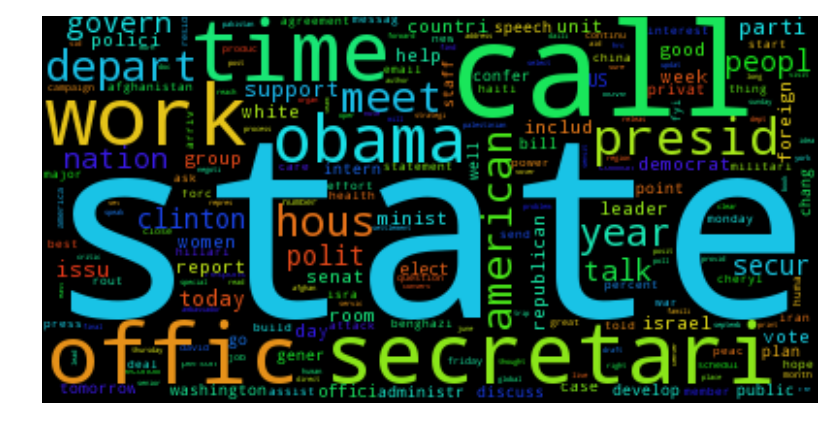

In [754]:
wordcloud = WordCloud().generate(raw_text)
plt.subplots(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

One problem now, is that we have words that are not actual words. For exemple, `secretary` was stemmed to `secretari`, which doesn't exist.

### Lemmatization

We apply the same concept of reducing each token to a more general form as in stemming. However, we will reduce to the root form of the token, not to its stem.

In [755]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [756]:
def lemmantizer(row_tokens) :
    return [lemmatizer.lemmatize(token) for token in row_tokens]

In [757]:
lemmas = filtered_tokens.apply(lambda row: lemmantizer(row))
lemmas.head(5)

0                                                [wow]
1    [thursday, march, 2011, latest, syria, aiding,...
2                                  [chris, stevensthx]
3                         [cairo, condemnation, final]
4    [friday, march, 11, 2011, huma, abedin, latest...
Name: EmailText, dtype: object

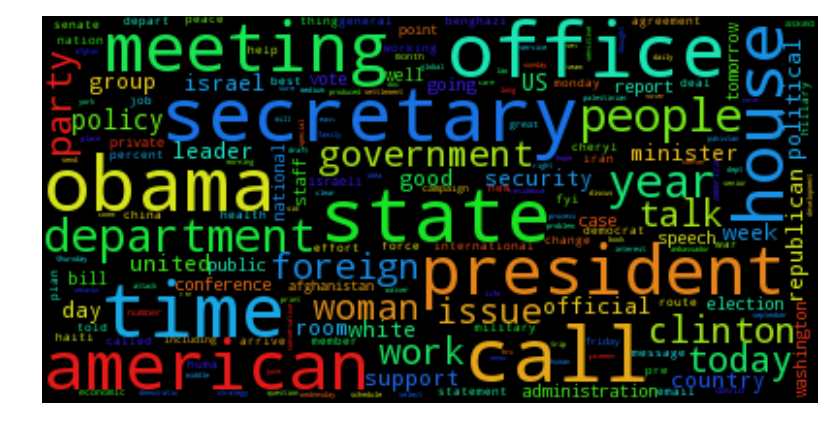

In [758]:
wordcloud = WordCloud(max_font_size=40).generate(join(lemmas))
plt.subplots(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We can see that this is much more satisfying.

## Part 2 - Countries

In [759]:
import pycountry
import difflib

Function to make sure we keep US in capitals letters to avoid confusion with noun "us"

In [760]:
def lower_case(country) :
    return country.lower() if country != 'US' else country

List of countries wich representation in pycountry's library is different to the common country's name

In [761]:
short_names = {'Palestine, state of':'palestine', 
               'United States': 'US', 
               'Venezuela, Bolivarian Republic of':'venezuela',
               'Russian Federation':'russia',
               'Syrian Arab Republic':'syria',  
               'Holy See (Vatican City State)':'vatican', 
               'Taiwan, Province of China':'taiwan', 
               'Macedonia, Republic of':'macedonia',  
               'Moldova, Republic of': 'moldova', 
               'Congo, The Democratic Republic of the':'congo'}

Return the common name of a country based on our previous list

In [762]:
def get_name(name) :
    return short_names.get(name) if name in short_names else name.lower()

Dictionary with all possible representations of a country's name mapped to his common name

In [763]:
country_dic_list = [ { get_name(x.name)    : get_name(x.name),
                      lower_case(x.alpha_2) : get_name(x.name), 
                      lower_case(x.alpha_3) : get_name(x.name)} for x in pycountry.countries ]

country_dic = {k: v for dic in country_dic_list for k, v in dic.items()}

Replace occurrences of a country's name in a list of tokens by his common name 

In [764]:
def contries_cleaner(tokens) :
    return [item if item not in country_dic else country_dic.get(item) for item in tokens]

Extract all countries in a list of tokens

In [765]:
def countries_in_mail(tokens) :
    countries = list(set([item for item in tokens if item in country_dic]))
    return countries if len(countries) != 0 else np.nan

For each mail replace occurences of country's name by his common's name

In [766]:
lemma_mails = lemmas.apply(lambda row: contries_cleaner(row))


Get a list of countries by mail

In [767]:
countries = list(lemma_mails.apply(lambda row: countries_in_mail(row)))

Join tokens in each mail

In [768]:
mail_words = [' '.join(tokens) for tokens in lemma_mails]

For each email list all countries mentioned

In [769]:
mails_countries = pd.DataFrame({'countries': countries, 'mails': mail_words}, 
                               columns=['mails', 'countries'])
mails_countries.head(5)

,mails,countries
0,wow,NaN
1,thursday march 2011 latest syria aiding qaddaf...,"[libya, syria]"
2,chris stevensthx,NaN
3,cairo condemnation final,NaN
4,friday march 11 2011 huma abedin latest syria ...,"[libya, syria]"


Drop all nan since they are not talking about any country

In [770]:
mails_countries = mails_countries.dropna()
mails_countries.head(5)

,mails,countries
1,thursday march 2011 latest syria aiding qaddaf...,"[libya, syria]"
4,friday march 11 2011 huma abedin latest syria ...,"[libya, syria]"
6,film director hiding libya egypt violence,"[libya, egypt]"
7,friday march 11 2011 huma abedin latest syria ...,"[libya, syria]"
9,wednesday september 12 2012 fwd libya libya 37...,[libya]


Perform a sentiment study based on demo_vader_instance method

In [771]:
from nltk.sentiment import SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()
v_sentiments = [vader_analyzer.polarity_scores(mail) for mail in mails_countries.mails]

We'll get the compound value in the output provides the sentiment intensity and will be in the range of -1 (Extremely negative) to 1 (Extremely positive).  

In [772]:
sentiments = [item['compound'] for item in v_sentiments]

In [773]:
vader_sentiments = mails_countries
vader_sentiments['sentiment'] = sentiments
vader_sentiments.head()

,mails,countries,sentiment
1,thursday march 2011 latest syria aiding qaddaf...,"[libya, syria]",0.000
4,friday march 11 2011 huma abedin latest syria ...,"[libya, syria]",0.000
6,film director hiding libya egypt violence,"[libya, egypt]",-0.743
7,friday march 11 2011 huma abedin latest syria ...,"[libya, syria]",0.000
9,wednesday september 12 2012 fwd libya libya 37...,[libya],0.000


Get sentiment's aggregation and number of occurrences in mails for each country

In [774]:
def sentiments_citation_by_country(mails_countries) :
    countries_compound = {}
    citations = {}
    for mail, countries, sentiment in mails_countries[['countries', 'sentiment']].itertuples() :
        for country in countries :
            if(country in countries_compound) :
                countries_compound[country] += sentiment
                citations[country] += 1
            else :
                countries_compound[country] = sentiment
                citations[country] = 1
    return countries_compound, citations

In [775]:
vader_compound, citations = sentiments_citation_by_country(vader_sentiments)

DataFrame with countries, sums of sentiments and number of occurrences

In [776]:
def get_country_data(countries_sent, citations) :
    country_data = [(k, v, citations[k]) 
                        for k, v in countries_sent.items()]
    country_data = pd.DataFrame(
                        country_data, 
                        columns=['countries', 'sentiment_sum', 'occurrences'])
    country_data.set_index('countries', inplace=True)
    return country_data

In [777]:
vader_country_data = get_country_data(vader_compound, citations)

Add sentiment average

In [778]:
vader_country_data['sentiment'] = vader_country_data['sentiment_sum'] / vader_country_data['occurrences']
vader_country_data.head(5)

,sentiment_sum,occurrences,sentiment
countries,,,
"micronesia, federated states of",23.8313,116,0.205442
belgium,0.4324,8,0.054050
norway,4.1507,13,0.319285
bangladesh,1.7147,11,0.155882
nicaragua,16.9746,43,0.394758


Sort by number of occurences and take the 20 most significant countries

In [779]:
vader_country_data = vader_country_data.sort_values('occurrences')
vader_country_data = vader_country_data[-25:]
vader_country_data

,sentiment_sum,occurrences,sentiment
countries,,,
france,2.3926,34,0.070371
ireland,8.7574,34,0.257571
brazil,11.3319,35,0.323769
turkey,11.8253,35,0.337866
jamaica,16.8746,37,0.456070
egypt,11.9647,41,0.291822
mexico,11.6766,43,0.271549
nicaragua,16.9746,43,0.394758
honduras,8.5036,52,0.163531


Sort values by sentiment for ploting purpose 

In [780]:
vader_country_data.sort_values('sentiment', inplace=True)

We set the neutral value in zero and scale the values and color scale to range between -1 and +1

In [781]:
def plot_data(data):
    # http://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value
    from matplotlib import cm

    # Set up colors : red to green
    y = np.array(data.sentiment)
   
    y = y / max(abs(y))
    cy = np.append(y, [-1, 1])
    
    c = (y + 1) / 2
    colors = cm.RdYlGn(c)
    plot = plt.scatter(cy, cy, c=cy, cmap = 'RdYlGn')
    plt.clf()
    clb = plt.colorbar(plot)
    clb.ax.set_title("Sentiment")

    # Display bar plot : country frequency vs. country name, with color indicating polarity score
    plt.bar(range(data.shape[0]), data.occurrences, align='edge', tick_label=data.index, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Country")
    plt.ylabel("Frequency")
    plt.show()

Sentiment for the most mentioned countries using the vader demo method is mostly positive.

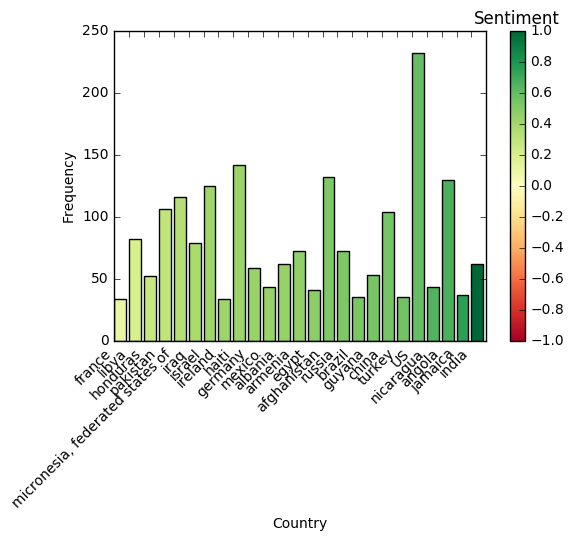

In [782]:
plot_data(vader_country_data)

Perform a sentiment study based on demo_liu_hu_lexicon method

In [783]:
from nltk.corpus import opinion_lexicon

Keep tokens and countries from mails

In [784]:
tokens_countries = pd.DataFrame({'tokens': lemma_mails, 'countries':countries}, 
                               columns=['tokens', 'countries'])
tokens_countries = tokens_countries.dropna()
tokens_countries.head(5)

,tokens,countries
1,"[thursday, march, 2011, latest, syria, aiding,...","[libya, syria]"
4,"[friday, march, 11, 2011, huma, abedin, latest...","[libya, syria]"
6,"[film, director, hiding, libya, egypt, violence]","[libya, egypt]"
7,"[friday, march, 11, 2011, huma, abedin, latest...","[libya, syria]"
9,"[wednesday, september, 12, 2012, fwd, libya, l...",[libya]


Get polarity using the lexicon liu hu method and keep values between -1 (all negative) +1 (all positive)

In [785]:
positive = set(opinion_lexicon.positive())
negative = set(opinion_lexicon.negative())
def liu_hu_lexicon(tokens):
    polarity = 0
    count = 0
    for word in tokens:
        if word in positive:
            polarity += 1 #positive
            count += 1
        elif word in negative:
            polarity -= 1 # negative
            count += 1
    return polarity / count if count != 0 else 0    

Add the sentiments for each tokenized mail

In [786]:
lexicon_countries = tokens_countries
lexicon_countries['sentiment'] = [liu_hu_lexicon(tokens) for tokens in  tokens_countries.tokens]
lexicon_countries.head()

,tokens,countries,sentiment
1,"[thursday, march, 2011, latest, syria, aiding,...","[libya, syria]",0.0
4,"[friday, march, 11, 2011, huma, abedin, latest...","[libya, syria]",0.0
6,"[film, director, hiding, libya, egypt, violence]","[libya, egypt]",0.0
7,"[friday, march, 11, 2011, huma, abedin, latest...","[libya, syria]",0.0
9,"[wednesday, september, 12, 2012, fwd, libya, l...",[libya],0.0


Get sentiment's aggregation and number of occurrences in mails for each country

In [787]:
lexicon_sentiment, citation = sentiments_citation_by_country(lexicon_countries)

DataFrame with countries, sums of sentiments and number of occurrences

In [788]:
lexicon_country_data = get_country_data(lexicon_sentiment, citation)

Add the average of sentiments to the data frame

In [789]:
lexicon_country_data['sentiment'] = lexicon_country_data['sentiment_sum'] / lexicon_country_data['occurrences']
lexicon_country_data.head()

,sentiment_sum,occurrences,sentiment
countries,,,
"micronesia, federated states of",13.443569,116,0.115893
belgium,-0.175729,8,-0.021966
norway,2.957270,13,0.227482
bangladesh,2.183117,11,0.198465
nicaragua,14.310512,43,0.332803


Sort by number of occurences and take the 20 most significant countries

In [790]:
lexicon_country_data = lexicon_country_data.sort_values('occurrences')
lexicon_country_data = lexicon_country_data[-25:]
lexicon_country_data

,sentiment_sum,occurrences,sentiment
countries,,,
france,-2.181289,34,-0.064156
ireland,0.992688,34,0.029197
brazil,3.588248,35,0.102521
turkey,3.406509,35,0.097329
jamaica,14.821812,37,0.400590
egypt,2.170833,41,0.052947
mexico,5.202011,43,0.120977
nicaragua,14.310512,43,0.332803
honduras,6.409442,52,0.123259


Sort data by sentiment for ploting purpose

In [791]:
lexicon_country_data.sort_values('sentiment', inplace=True)

The sentiments using the lexicon demo method seems also mostly positive

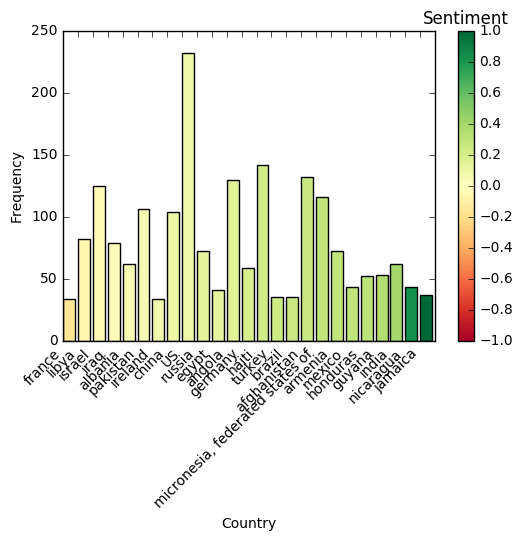

In [792]:
plot_data(lexicon_country_data)

Both methods have bias towards positive sentiments. We observe variations in the ranking of countries like US it could be attributed to its high number of occurences (omnipresent in the emails regardless of the subject). 

## Part 3 - Topic Modeling 

In [793]:
from gensim import corpora
import gensim

In this part we are going to use the raw text to get the threads of emails

In [794]:
raw_text = data['RawText']

Most of emails start and end by an unusefull set of lines, we are going to get rid of them 

In [795]:
head_start_words = ('UNCLASSIFIED', 'U.S.', 'Case', 'Doc', 'Date:', 'STATE', 'SUBJECT', 'RELEASE', 'From:', 'Sent:', 'To:', 'FW:', 'FVV:', '\x0c')
def delete_headers(mails) :
    mails = mails.split('\n')
    mails = [lines for lines in mails if not lines.startswith(head_start_words)]
    return ' '.join(mails)


In [796]:
threads_mails = [delete_headers(mail) for mail in raw_text]
threads_mails[:1]

['Subject: FW: Wow Subject: Wow What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me too']

We tokenize, lower case, filter and lemmantize this threads exactly how we do in the first part.

In [797]:
threads_tokens = [tokenizer(mail) for mail in threads_mails]

lower_case_tokens = [to_lower_case(mail) for mail in threads_tokens]

filtered_threads = [filter_tokens(mail) for mail in lower_case_tokens]

lemma_threads = [lemmantizer(mail) for mail in filtered_threads]

Build a dictionary of words and vectorize the threads

In [798]:
dictionary = corpora.Dictionary(lemma_threads)

corpus = [dictionary.doc2bow(threads) for threads in lemma_threads if len(threads) > 5]


In [799]:
lda = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20)

We define number of topics and number of words in topics, we explored different number of topics and decided to keep 15, note that this strongly depends on appreciation 

In [815]:
num_topics = 15
num_top_words = 10

Run the model for each mails

In [816]:
word_topic = lda.show_topics(num_topics=num_topics, num_words=num_top_words, log=False, formatted=False)
word_topic = [topics for (topicId, topics) in word_topic]

Convert the topics in array for plot pourpose

In [817]:
word_topic_array = np.array(word_topic)


In [818]:
word_topics_score = [ float(value) for topics in word_topic_array for value in topics[:,1]]
max_score = np.max(word_topics_score)

We plot only 4 topics for better visualization

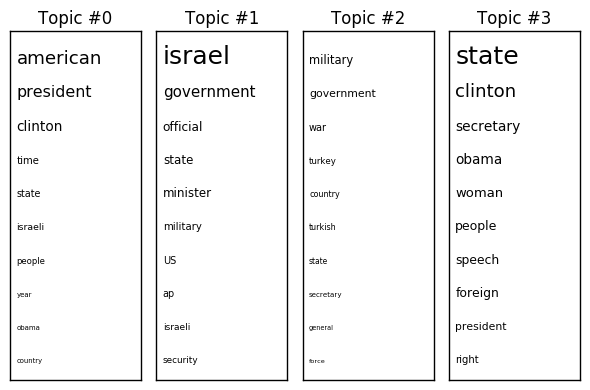

In [824]:
import matplotlib.pyplot as plt

fontsize_base = 70 / max_score  # font size for word with largest share in corpus
num_columns = 4

for topic in range(num_columns):
    plt.subplot(1, num_columns, topic + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(topic))
    
    for i, (word, share) in enumerate(word_topic_array[topic,:]):
        font_size = fontsize_base*float(share)
        plt.text(0.05, num_top_words-i-0.5, word, fontsize=font_size) 
    
plt.tight_layout()